# Setup




In [334]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from IPython.display import Javascript
from nbconvert import HTMLExporter
import time

def save_notebook():
    display(
        Javascript("IPython.notebook.save_notebook()"),
        include=['application/javascript']
    )

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)
current_file = 'TAD_VAE_construction.ipynb'

## Set notebook output name here:
output_file = 'TAD_VAE_local_fullseq_encoded_01Norm.html'

# Data Import and Split


In [335]:
np.random.seed(42)

## randomly select ~44k TCRs from MAIT pool - this saves having to import the whole dataset only to subset later.
rng = np.random.default_rng()
files = rng.choice(range(1,98), size=97, replace=False)

## Read in data
data = []
## TODO: write method to save names of files used in training/testing
for i in range(1,98):
    data.append(pd.read_csv("../data/mait/pbert/MAIT_betaSeq_recon_"+str(i)+"_pbert_local.csv", header=None))
mait_loc = pd.concat(data, axis=0, ignore_index=False)

del data
mait_local = mait_loc.to_numpy()
del mait_loc

data = []
## max here is 133
files = rng.choice(range(1,95), size=94, replace=False)
for i in range(1,95):
    data.append(pd.read_csv("../data/tcr_beta/pbert/tcr_beta_seq_"+str(i)+"_pbert_local.csv", header=None))
vdjdb_loc = pd.concat(data)
del data
vdjdb_local = vdjdb_loc.to_numpy()
print(vdjdb_local.shape)
del vdjdb_loc

data = np.append(mait_local, vdjdb_local, axis=0)

labels = np.repeat([1,0], [mait_local.shape[0], vdjdb_local.shape[0]], axis=0)
print("done")

(93856, 1562)
done


In [336]:
print(mait_local.shape)
print(vdjdb_local.shape)
print(mait_local.shape[0] + vdjdb_local.shape[0])
print(data.shape)

print(labels)

unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

(96235, 1562)
(93856, 1562)
190091
(190091, 1562)
[1 1 1 ... 0 0 0]


{0: 93856, 1: 96235}


Correct number of MAIT and VDJDB entries in the concatenated dataset, and the data appears to be labelled correctly.


Take all available VDJdb data, without randomization because it could be useful to add on HLA haplotypes, etc, for visualisation later.

Do I need to normalise the data?

In [337]:

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42
)
## Center normalization
#mean_val = tf.reduce_mean(train_data)
#train_data = train_data - mean_val
#test_data = test_data - mean_val

## Min/Max 0,1 normalization
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

### Standardized normalisation (center, scaled)
#train_centered = train_data - mean_val
#test_centered = test_data - mean_val
#min_val = tf.reduce_min(train_data)
#max_val = tf.reduce_max(train_data)
#train_scaled = (train_data - min_val) / (max_val - min_val)
#test_scaled = (test_data - min_val) / (max_val - min_val)
#train_data = (train_centered * train_scaled)
#test_data = (test_centered * test_scaled)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)
print("done")

done


Check shape and values in train and test data objects

In [338]:
print("Data object dimensionality \n")
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

Data object dimensionality 

(152072, 1562)
(38019, 1562)
(152072,)
(38019,)


In [339]:
print("Train label counts")
print(train_labels)
unique, counts = np.unique(train_labels, return_counts=True)
dict(zip(unique, counts))

Train label counts
[0 0 1 ... 0 0 0]


{0: 75069, 1: 77003}

In [340]:
print("Test label counts")
print(test_labels)
unique, counts = np.unique(test_labels, return_counts=True)
dict(zip(unique, counts))

Test label counts
[0 0 0 ... 0 1 0]


{0: 18787, 1: 19232}


train and test data objects are of correct size and shape. Corresponding label objects match length of their data objects. Counts of labels are balanced +/- <100 values.

TODO: figure out what this next chunk actually is doing, is the anomalous data actually using MAIT or is it Non-MAIT?
Here, the tensor objects train/test _data are being sliced by a boolean object, 1 (MAIT) are treated as TRUE meaning anomalous?, 0 (VDJDB) are FALSE and treated as anomalous?

In [341]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]
print("done")

done


In [342]:
print(train_labels)

[False False  True ... False False False]


# Define VAE

In [343]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
print("done")

done


In [344]:
def encoder_model(normal_train_data):
    encoder_inputs = tf.keras.Input(shape=(normal_train_data.shape[1],))
    x = layers.Dense(256, activation="relu")(encoder_inputs)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)

    # So far we just copied the network from above
    # Now we generate the latent space of mean and log-variance, in this case of dimension 8
    z_mean = layers.Dense(64, name="z_mean")(x)
    z_log_var = layers.Dense(64, name="z_log_var")(x)

    # Sample from these distributions
    z = Sampling()([z_mean, z_log_var])
    #encoder = tf.keras.Model(encoder_inputs, z, name="encoder")
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

In [345]:
def decoder_model(normal_train_data):
    # Recreate the network we used for the 'normal' autoencoder
    latent_inputs = tf.keras.Input(shape=(64,))
    x = layers.Dense(128, activation="relu")(latent_inputs)
    x = layers.Dense(256, activation="relu")(x)
    decoder_outputs = layers.Dense(normal_train_data.shape[1], activation="relu")(x)
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder


In [346]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
print("done")

done


In [347]:
# Get the encoder and decoder models
encoder = encoder_model(normal_train_data)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 1562)]       0           []                               
                                                                                                  
 dense_54 (Dense)               (None, 256)          400128      ['input_19[0][0]']               
                                                                                                  
 dense_55 (Dense)               (None, 128)          32896       ['dense_54[0][0]']               
                                                                                                  
 dense_56 (Dense)               (None, 64)           8256        ['dense_55[0][0]']               
                                                                                            

In [348]:
decoder = decoder_model(normal_train_data)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 64)]              0         
                                                                 
 dense_57 (Dense)            (None, 128)               8320      
                                                                 
 dense_58 (Dense)            (None, 256)               33024     
                                                                 
 dense_59 (Dense)            (None, 1562)              401434    
                                                                 
Total params: 442,778
Trainable params: 442,778
Non-trainable params: 0
_________________________________________________________________


In [349]:
# Get the combined model
vae = VAE(encoder, decoder)

# Compile the model
## usually lr 0.0001 and 0.00001 works better than 0.01
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))


# Model Fit

In [350]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Maybe try adding an early stopping function?
earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="loss",
                                        mode ="min", patience = 5,
                                        restore_best_weights = True)

# Fit the model to the training set
history = vae.fit(normal_train_data, normal_train_data,
          epochs=80,
          batch_size=128,
          shuffle=True,
          callbacks= [earlystopping, lr_scheduler])
print("done")

Epoch 1/80
602/602 [==============================] - 13s 20ms/step - loss: 0.8645 - reconstruction_loss: 0.8607 - kl_loss: 0.0037 - lr: 1.0000e-04
Epoch 2/80
602/602 [==============================] - 14s 23ms/step - loss: 0.6588 - reconstruction_loss: 0.6587 - kl_loss: 1.3292e-04 - lr: 1.0000e-04
Epoch 3/80
602/602 [==============================] - 12s 20ms/step - loss: 0.6474 - reconstruction_loss: 0.6473 - kl_loss: 1.3778e-04 - lr: 1.0000e-04
Epoch 4/80
602/602 [==============================] - 10s 17ms/step - loss: 0.6409 - reconstruction_loss: 0.6408 - kl_loss: 1.0368e-04 - lr: 1.0000e-04
Epoch 5/80
602/602 [==============================] - 10s 17ms/step - loss: 0.6366 - reconstruction_loss: 0.6365 - kl_loss: 1.0440e-04 - lr: 1.0000e-04
Epoch 6/80
602/602 [==============================] - 10s 17ms/step - loss: 0.6334 - reconstruction_loss: 0.6333 - kl_loss: 1.0651e-04 - lr: 1.0000e-04
Epoch 7/80
602/602 [==============================] - 10s 16ms/step - loss: 0.6309 - reconst

In [351]:
print("Current learning rate =", tf.keras.backend.eval(vae.optimizer.lr))

Current learning rate = 4.5049223e-06


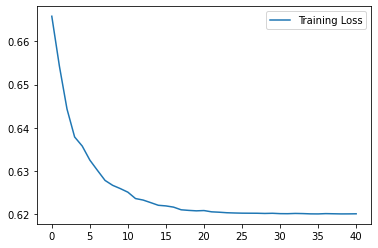

In [352]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()

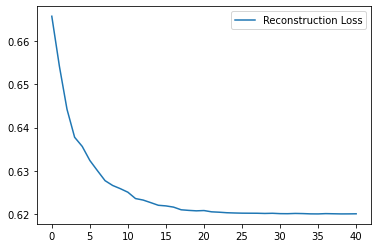

In [353]:
plt.plot(history.history["reconstruction_loss"], label="Reconstruction Loss")
plt.legend()

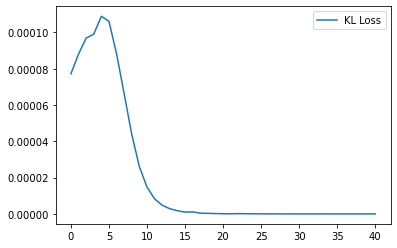

In [354]:
plt.plot(history.history["kl_loss"], label="KL Loss")
plt.legend()

In [355]:
### use this from xenia
encoded_inputs = vae.encoder.predict(normal_train_data)
test_reconstructions = vae.decoder.predict( encoded_inputs[2] )

In [356]:

train_loss = tf.keras.losses.mae(test_reconstructions, normal_train_data)

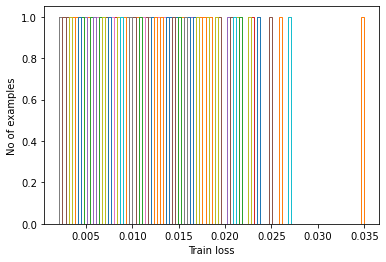

In [357]:
plt.hist(train_loss, bins=100, histtype="step")
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [358]:
threshold_vae = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold_vae)

Threshold:  0.0055851955


In [359]:
encoded_anomaly = vae.encoder.predict(anomalous_test_data)
reconstructions = vae.decoder.predict( encoded_anomaly[2] )
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

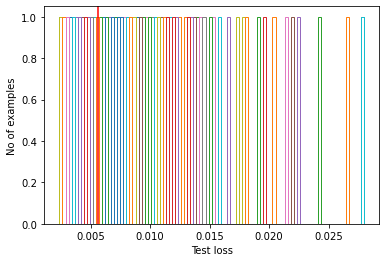

In [360]:
plt.hist(test_loss, bins=100, histtype="step")
plt.axvline(threshold_vae,c='r')
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

# Metrics

MAIT = 1
VDJDB = 0

In [361]:
def predict(model, data, threshold):
  encoded_data = model.encoder.predict(data)
  reconstructions = model.decoder.predict( encoded_data[2] )
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(metrics.accuracy_score(labels, preds)))
  print("Balanced Accuracy = {}".format(metrics.balanced_accuracy_score(labels, preds)))
  print("Precision = {}".format(metrics.precision_score(labels, preds)))
  print("Recall = {}".format(metrics.recall_score(labels, preds)))

def f1_score(preds, labels):
    precision = metrics.precision_score(labels, preds)
    recall = metrics.recall_score(labels, preds)
    f1 = 2 * (precision * recall)/(precision + recall)
    print("F1 Score = {}".format(f1))

In [362]:
preds = predict(vae, test_data, threshold_vae)
print("Variational Autoencoder")
print_stats(preds, test_labels)
f1_score(preds, test_labels)

Variational Autoencoder
Accuracy = 0.5021173623714459
Balanced Accuracy = 0.49751707517907867
Precision = 0.5044623133339224
Recall = 0.8905470049916805
F1 Score = 0.6440779948479778


In [363]:
metrics.confusion_matrix(test_labels, preds)

array([[ 1963, 16824],
       [ 2105, 17127]])

In [364]:
print(metrics.classification_report(test_labels, preds))

              precision    recall  f1-score   support

       False       0.48      0.10      0.17     18787
        True       0.50      0.89      0.64     19232

    accuracy                           0.50     38019
   macro avg       0.49      0.50      0.41     38019
weighted avg       0.49      0.50      0.41     38019



# MTB TCR Predictions



In [365]:
mtb = pd.read_csv("../data/MTB_mr1t_fullbeta_pBERT_local.csv", header=None)
mtb_data = mtb.to_numpy()
del mtb
mtb_labels = np.repeat(1, mtb_data.shape[0], axis=0)

min_val = tf.reduce_min(mtb_data)
max_val = tf.reduce_max(mtb_data)
mtb_data = (mtb_data - min_val) / (max_val - min_val)

mtb_pred = predict(vae, mtb_data, threshold_vae)
print("done")

done


In [366]:
print("Accuracy = {}".format(metrics.accuracy_score(mtb_labels, mtb_pred)))
print("Balanced Accuracy = {}".format(metrics.balanced_accuracy_score(mtb_labels, mtb_pred)))
print("Precision = {}".format(metrics.precision_score(mtb_labels, mtb_pred)))
print("Recall = {}".format(metrics.recall_score(mtb_labels, mtb_pred)))

Accuracy = 0.6851851851851852
Balanced Accuracy = 0.6851851851851852
Precision = 1.0
Recall = 0.6851851851851852


/Users/julianspagnuolo/opt/miniconda3/envs/tcr-anomaly-detector/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [371]:
print(metrics.confusion_matrix(mtb_labels, mtb_pred))

[[ 0  0]
 [17 37]]


In [368]:
print(metrics.classification_report(mtb_labels, mtb_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.69      0.81        54

    accuracy                           0.69        54
   macro avg       0.50      0.34      0.41        54
weighted avg       1.00      0.69      0.81        54



/Users/julianspagnuolo/opt/miniconda3/envs/tcr-anomaly-detector/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/julianspagnuolo/opt/miniconda3/envs/tcr-anomaly-detector/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/julianspagnuolo/opt/miniconda3/envs/tcr-anomaly-detector/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control


# Render Notebook


In [372]:
save_notebook()
time.sleep(3)
output_HTML(current_file, output_file)